# Test new model

In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
import numpy as np
existence_matrix = np.zeros((num_users, num_items))
for user_index, item_index in zip(users_train, items_train):
    existence_matrix[user_index, item_index] = 1
A = torch.FloatTensor(existence_matrix)

In [4]:
class ML100KMatrix(torch.utils.data.Dataset):
    def __init__(self, users, existence_matrix):
        self.users = users
        self.A = existence_matrix

    def __getitem__(self, index):
        return (self.users[index], self.A[self.users[index]])

    def __len__(self):
        return len(self.users)

In [5]:
batch_size = 1024
trainset = ML100KMatrix(users_train, A)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
len(train_loader)

98

## Model Config

In [7]:
from gcn.vae import RatingModel
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 64
model = RatingModel(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 64, learning_rate: 0.01, weight_decay: 1e-05


## Train

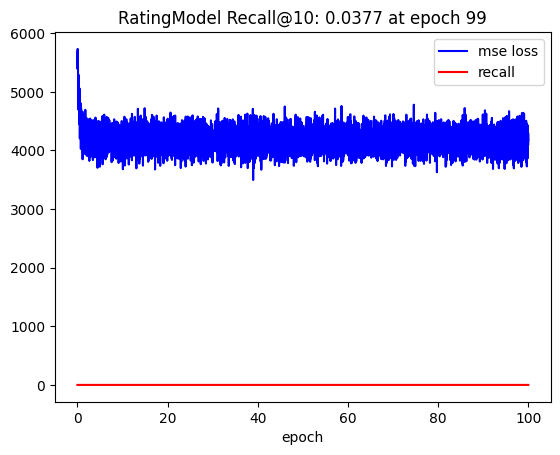

RatingModel Recall@10: 0.0377 at epoch 99


In [8]:
from gcn.train import evaluate_ranking
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users = values[0].to(device)
        ratings = values[1].to(device)
        # Forward pass
        scores = model(users)
        loss = loss_fn(scores, ratings)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'RatingModel Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'RatingModel Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')

ani.close()

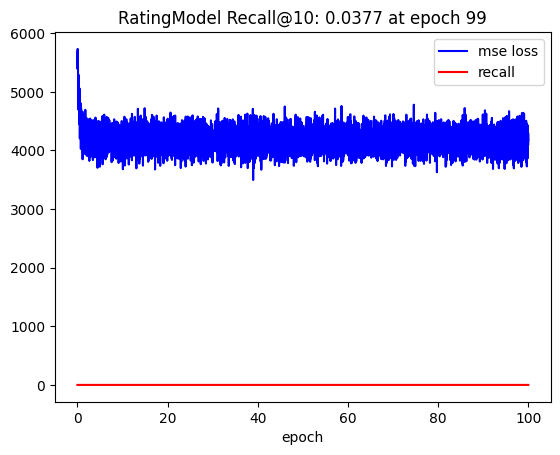

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.xlabel("epoch")
plt.legend()
plt.title(f'RatingModel Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
plt.savefig(f'./images/RatingModel Embed_dim: {n_factors} Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}.png')
plt.show()

In [10]:
recall_list

[0.0,
 0.07049180327868852,
 0.06885245901639345,
 0.05901639344262295,
 0.06885245901639345,
 0.06721311475409836,
 0.07213114754098361,
 0.07049180327868852,
 0.07868852459016394,
 0.07049180327868852,
 0.06557377049180328,
 0.06393442622950819,
 0.060655737704918035,
 0.05573770491803279,
 0.05573770491803279,
 0.05573770491803279,
 0.054098360655737705,
 0.05245901639344262,
 0.05245901639344262,
 0.05081967213114754,
 0.054098360655737705,
 0.04918032786885246,
 0.05245901639344262,
 0.05245901639344262,
 0.04590163934426229,
 0.04590163934426229,
 0.04918032786885246,
 0.047540983606557376,
 0.04590163934426229,
 0.047540983606557376,
 0.047540983606557376,
 0.047540983606557376,
 0.047540983606557376,
 0.04590163934426229,
 0.04426229508196721,
 0.04262295081967213,
 0.040983606557377046,
 0.03934426229508197,
 0.03934426229508197,
 0.040983606557377046,
 0.03934426229508197,
 0.03934426229508197,
 0.03934426229508197,
 0.03934426229508197,
 0.03934426229508197,
 0.0393442622950

In [11]:
# max(recall_list), min(rmse_list) 
print(f'RatingModel Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')

RatingModel Max Recall@10: 0.0787 at epoch 8
